# Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. 

Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.


Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. 


Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.


Идея решения задачи от заказчика: 
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
    
    
Заказчик предлагает поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

Краткое описание таблиц:
- collisions — общая информация о ДТП

    - Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- parties — информация об участниках ДТП

    - Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
- vehicles — информация о пострадавших машинах

    - Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Импорт необходимых библиотек

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import phik
from phik.report import plot_correlation_matrix

from sqlalchemy import create_engine

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import joblib

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report

import lightgbm as lgb

from catboost import CatBoostClassifier

## Подключимся к базе. Загрузим таблицы sql

Подключимся к базе данных, используя данные:

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [6]:
engine = create_engine(connection_string)

Проверка количества таблиц
- Нам нужно убедиться, что у нас есть таблицы. Для этого можно использовать запрос к системной таблице information_schema.tables.

In [7]:
query = '''
SELECT table_name
  FROM information_schema.tables
 WHERE table_schema = 'public'
'''

df = pd.read_sql_query(query, con=engine)
print(df)

   table_name
0    case_ids
1  collisions
2     parties
3    vehicles


In [8]:
query = '''
SELECT * 
  FROM collisions
'''
df = pd.read_sql_query(query, con=engine)
df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Успешно подключились!

## Первичное исследование таблиц

Выясним: 
- Все ли таблицы имеют набор данных;
- Имеется ли общий ключ для связи таблиц.


Для осмотра таблиц будем использовать sql-запрос.

Проверка наличия данных в таблицах:
- Для этого мы можем выполнить запросы, которые подсчитывают количество строк в каждой таблице.

In [9]:
# Запросы для подсчета количества строк в каждой таблице
queries = {
    'collisions': 'SELECT COUNT(*) FROM collisions',
    'parties': 'SELECT COUNT(*) FROM parties',
    'vehicles': 'SELECT COUNT(*) FROM vehicles'
}

# Выполнение запросов и вывод результатов
for table, query in queries.items():
    df = pd.read_sql_query(query, con=engine)
    print(f'Таблица {table} имеет {df.iloc[0, 0]} строк')

Таблица collisions имеет 1400000 строк
Таблица parties имеет 2752408 строк
Таблица vehicles имеет 1021234 строк


In [10]:
# Определение списка таблиц
tables = ['collisions', 'parties', 'vehicles']

# Вывод всех колонок и их типов данных для каждой таблицы
print("Вывод всех колонок и их типов данных для каждой таблицы")
for table in tables:
    query = f'''
    SELECT
        column_name,
        data_type
    FROM 
        information_schema.columns
    WHERE 
        table_name = '{table}'
    '''
    df = pd.read_sql_query(query, con=engine)
    print(f'Колонки в таблице {table}:')
    display(df)
    print('\n')

Вывод всех колонок и их типов данных для каждой таблицы
Колонки в таблице collisions:


,column_name,data_type
0,party_count,integer
1,intersection,integer
2,distance,real
3,collision_date,date
4,collision_time,time without time zone
5,location_type,text
6,collision_damage,text
7,case_id,text
8,pcf_violation_category,text
9,type_of_collision,text




Колонки в таблице parties:


,column_name,data_type
0,cellphone_in_use,integer
1,party_number,integer
2,at_fault,integer
3,insurance_premium,integer
4,id,integer
5,case_id,text
6,party_drug_physical,text
7,party_type,text
8,party_sobriety,text




Колонки в таблице vehicles:


,column_name,data_type
0,id,integer
1,party_number,integer
2,vehicle_age,integer
3,case_id,text
4,vehicle_type,text
5,vehicle_transmission,text


In [11]:
# query = '''
# SELECT table_name
#   FROM information_schema.tables
#  WHERE table_schema = 'public'
# '''

# df = pd.read_sql_query(query, con=engine)
# print(df)

In [12]:
# Проверка наличия ключа case_id в каждой таблице через схему базы данных
print("Проверка наличия общего ключа case_id в каждой таблице через схему базы данных")
tables = ['collisions', 'parties', 'vehicles']
for table in tables:
    query = f'''
    SELECT column_name
      FROM information_schema.columns
     WHERE table_name = '{table}'
       AND column_name = 'case_id'
    '''
    df = pd.read_sql_query(query, con=engine)
    if not df.empty:
        print(f'Таблица {table} имеет case_id')
    else:
        print(f'Таблица {table} не имеет case_id')

Проверка наличия общего ключа case_id в каждой таблице через схему базы данных
Таблица collisions имеет case_id
Таблица parties имеет case_id
Таблица vehicles имеет case_id


In [13]:
# Запрос для получения информации о ключах
query = '''
SELECT 
    constraint_name,
    table_name,
    column_name
FROM 
    information_schema.key_column_usage
WHERE 
    table_name IN ('collisions', 'parties', 'vehicles')
'''

df = pd.read_sql_query(query, con=engine)
print(df)

                  constraint_name  table_name column_name
0  collisions_case_ids_case_id_fk  collisions     case_id
1                      parties_pk     parties          id
2     parties_case_ids_case_id_fk     parties     case_id
3                     vehicles_pk    vehicles          id
4    vehicles_case_ids_case_id_fk    vehicles     case_id


Можно заметить, что отсутствует первичный ключ у таблицы collisions.

In [14]:
# Запрос для проверки уникальности значений столбца case_id в таблице collisions
query = '''
SELECT
    COUNT(*) AS total_rows,
    COUNT(DISTINCT case_id) AS unique_case_ids
FROM
    collisions
'''

df = pd.read_sql_query(query, con=engine)
print(df)

# Проверка уникальности
total_rows = df['total_rows'][0]
unique_case_ids = df['unique_case_ids'][0]

if total_rows == unique_case_ids:
    print("Все значения в столбце case_id уникальны.")
else:
    print("Не все значения в столбце case_id уникальны.")

   total_rows  unique_case_ids
0     1400000          1400000
Все значения в столбце case_id уникальны.


Общий вывод по выполненным проверкам

- Мы выполнили запросы для подсчета количества строк в таблицах collisions, parties и vehicles.
- Результаты показали, что все три таблицы содержат данные.
- Мы выполнили запрос к системной таблице information_schema.tables, чтобы получить список всех таблиц в базе данных.
- Результаты показали, что в базе данных присутствуют все необходимые таблицы: collisions, parties и vehicles.

- Мы выполнили запрос к системной таблице information_schema.columns, чтобы проверить наличие столбца case_id в таблицах collisions, parties и vehicles.
- Результаты показали, что столбец case_id присутствует во всех трех таблицах.

- Мы выполнили запрос к системной таблице information_schema.key_column_usage, чтобы получить информацию о первичных и внешних ключах для таблиц collisions, parties и vehicles.
- Результаты показали, что в таблице collisions отсутствует явный первичный ключ.

- Все проведенные проверки подтверждают, что данные и таблицы в базе данных находятся в порядке.

Таким образом, база данных структурирована корректно и готова для дальнейшего анализа и работы.

##  Статистический анализ факторов ДТП

Выяснм, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений (таблица collisions).
- Создадим sql-запрос;
- Построим график;
- Сделаем вывод.

In [15]:
# SQL-запрос для подсчета количества аварий по месяцам
query = '''
SELECT 
    DATE_TRUNC('month', COLLISION_DATE) AS month,
    COUNT(*) AS accident_count
FROM 
    collisions
GROUP BY 
    month
ORDER BY 
    month;
'''

# Выполнение запроса и загрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)
print(df.head())

                       month  accident_count
0  2009-01-01 00:00:00+03:00           35062
1  2009-02-01 00:00:00+03:00           34480
2  2009-03-01 00:00:00+03:00           36648
3  2009-04-01 00:00:00+04:00           35239
4  2009-05-01 00:00:00+04:00           36916


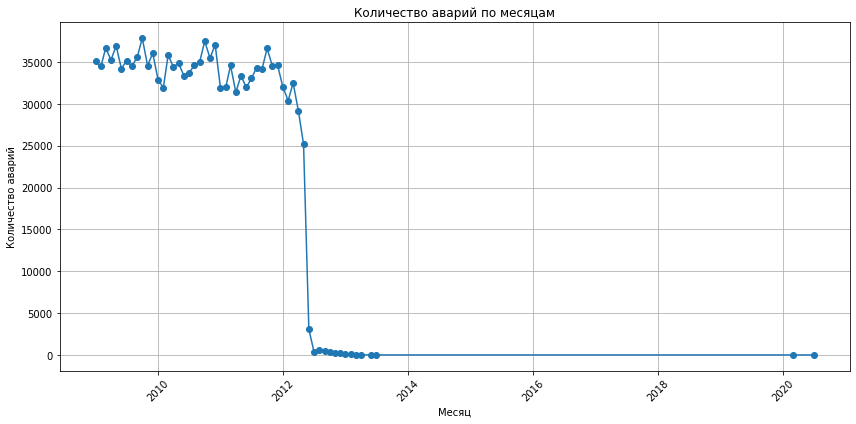

In [16]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['accident_count'], marker='o')
plt.title('Количество аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что данные представлены в основном до конца 2012 года, затем в будущие года представлены совсем небольшим количеством случаев.

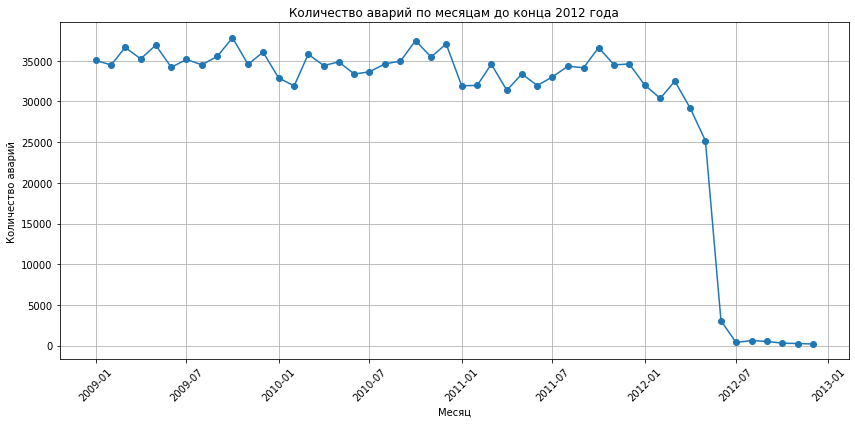

In [17]:
# SQL-запрос для подсчета количества аварий по месяцам до конца 2012 года
query = '''
SELECT 
    DATE_TRUNC('month', COLLISION_DATE) AS month,
    COUNT(*) AS accident_count
FROM 
    collisions
WHERE 
    COLLISION_DATE < '2013-01-01'
GROUP BY 
    month
ORDER BY 
    month;
'''

# Выполнение запроса и загрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['accident_count'], marker='o')
plt.title('Количество аварий по месяцам до конца 2012 года')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Найдем топ-5 месяцев с наибольшим количеством аварий
top_5_max = df.nlargest(5, 'accident_count').reset_index(drop=True)
top_5_max['rank'] = top_5_max.index + 1
top_5_max['type'] = 'max'

# Найдем топ-5 месяцев с наименьшим количеством аварий
top_5_min = df.nsmallest(5, 'accident_count').reset_index(drop=True)
top_5_min['rank'] = top_5_min.index + 1
top_5_min['type'] = 'min'

# Объединим данные в одну таблицу
top_5 = pd.concat([top_5_max, top_5_min], ignore_index=True)

# Получим результирующую таблицу
top_5

,month,accident_count,rank,type
0,2009-10-01 00:00:00+04:00,37835,1,max
1,2010-10-01 00:00:00+04:00,37480,2,max
2,2010-12-01 00:00:00+03:00,37070,3,max
3,2009-05-01 00:00:00+04:00,36916,4,max
4,2009-03-01 00:00:00+03:00,36648,5,max
5,2012-12-01 00:00:00+04:00,200,1,min
6,2012-11-01 00:00:00+04:00,253,2,min
7,2012-10-01 00:00:00+04:00,304,3,min
8,2012-07-01 00:00:00+04:00,390,4,min
9,2012-09-01 00:00:00+04:00,510,5,min


На основании представленных данных можно сделать следующие выводы:

- Пики аварийности:

    - Наибольшее количество аварий произошло в октябре 2009 года, с числом аварий 37,835.
    - Второе по величине количество аварий наблюдалось в октябре 2010 года, с числом аварий 37,480.
    - Высокие показатели аварийности также наблюдались в декабре 2010 года (37,070), мае 2009 года (36,916) и марте 2009 года (36,648).
    
    
- Минимумы аварийности:

    - Наименьшее количество аварий произошло в декабре 2012 года, с числом аварий 200.
    - Другие месяцы с минимальным количеством аварий включают ноябрь 2012 года (253), октябрь 2012 года (304), июль 2012 года (390) и сентябрь 2012 года (510).


- Общие тенденции:

    - Пики аварийности приходятся на месяцы 2009 и 2010 годов, что может быть связано с различными факторами, такими как сезонные изменения, увеличение транспортного потока или изменения в дорожных условиях и погоде.
    - Минимумы аварийности сосредоточены в 2012 году, особенно в конце года. Это может быть связано с различными факторами, такими как улучшение дорожной инфраструктуры, снижение транспортного потока, введение новых правил дорожного движения или улучшение погодных условий.


- Потенциальные факторы:

    - Сезонные факторы: Высокие показатели аварийности в октябре и декабре могут быть связаны с ухудшением погодных условий, таких как дождь или снег, а также с увеличением числа автомобилей на дорогах в связи с праздничными сезонами.
    - Изменение инфраструктуры: Резкое снижение числа аварий в 2012 году может указывать на улучшение дорожной инфраструктуры, внедрение новых правил безопасности или других мер, направленных на снижение аварийности.
    - Внешние факторы: Введение новых законов и правил, улучшение водительской дисциплины, кампании по повышению безопасности на дорогах также могут сыграть роль в снижении аварийности.

Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. 

Для этого мы должны создать подходящие аналитические задачи и поручить их решение коллегам. 


**Создадим не менее шести задач для коллег.** Опираться будем на таблицы. 

- Задача 1: Анализ влияния погодных условий на количество аварий
    - Цель: Определить, как различные погодные условия влияют на количество аварий.
    - Действия:
        - Выполнить SQL-запрос для подсчета количества аварий по разным погодным условиям (WEATHER_1) в таблице collisions.
        - Сравнить данные и построить график для визуализации.
    - Ответственный: Коллега 1
    
    
- Задача 2: Анализ тяжести аварий
    - Цель: Определить распределение тяжести аварий и выявить наиболее частые типы повреждений.
    - Действия:

        - Выполнить SQL-запрос для подсчета количества аварий по категориям тяжести повреждений (COLLISION_DAMAGE) в таблице collisions.
        - Построить график для визуализации распределения тяжести аварий.
    - Ответственный: Коллега 2
    
    
- Задача 3: Анализ аварий на перекрёстках и шоссе
    - Цель: Сравнить количество аварий, происходящих на перекрёстках и шоссе.
    - Действия:

        - Выполнить SQL-запрос для подсчета количества аварий по типу местоположения (LOCATION_TYPE) в таблице collisions.
        - Сравнить данные и построить график для визуализации.
    - Ответственный: Коллега 3
    
- Задача 4: Анализ аварий по категориям нарушений

    - Цель: Выявить наиболее частые категории нарушений, приводящие к авариям.
    - Действия:

        - Выполнить SQL-запрос для подсчета количества аварий по категориям нарушений (PCF_VIOLATION_CATEGORY) в таблице collisions.
        - Построить график для визуализации.
    - Ответственный: Коллега 4
    
    
- Задача 5: Анализ аварий по типам участников
    - Цель: Определить, какие типы участников чаще всего попадают в аварии.
    - Действия:

        - Выполнить SQL-запрос для подсчета количества аварий по типам участников (PARTY_TYPE) в таблице parties.
        - Построить график для визуализации.
    - Ответственный: Коллега 5
    
    
- Задача 6: Анализ аварий по возрасту транспортных средств
    - Цель: Определить, как возраст транспортных средств влияет на вероятность попадания в аварию.
    - Действия:

        - Выполнить SQL-запрос для подсчета количества аварий по возрасту транспортных средств (VEHICLE_AGE) в таблице vehicles.
        - Построить график для визуализации зависимости количества аварий от возраста транспортных средств.
    - Ответственный: Коллега 6

Пропишем порядок решения для 2-х задач и реализуем его:

- Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (свяжем collisions и parties);
- Найдем самые частые причины ДТП (таблица collisions)

Пример прописанного порядка:
- Создать sql-запрос;
- Построить графики;
- Сделать выводы.

**Задача 1: Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП**


- Порядок решения:

    - Создать SQL-запрос:

        - Связать таблицы collisions и parties по столбцу CASE_ID.
        - Выбрать столбцы ROAD_SURFACE, COLLISION_DAMAGE и подсчитать количество происшествий для каждой комбинации состояния дороги и серьёзности повреждений.
    - Построить графики:

        - Показать распределение серьёзности повреждений в зависимости от состояния дороги.

- Сделать выводы

In [19]:
# SQL-запрос для анализа серьёзности повреждений транспортного средства исходя из состояния дороги
query1 = '''
SELECT 
    c.ROAD_SURFACE,
    c.COLLISION_DAMAGE,
    COUNT(*) AS accident_count
FROM 
    collisions AS c
JOIN 
    parties AS p ON c.CASE_ID = p.CASE_ID
GROUP BY 
    c.ROAD_SURFACE, c.COLLISION_DAMAGE
ORDER BY 
    c.ROAD_SURFACE, c.COLLISION_DAMAGE;
'''

# Выполнение запроса и загрузка данных в DataFrame
df1 = pd.read_sql_query(query1, con=engine)
print(df1.head())

  road_surface collision_damage  accident_count
0          dry            fatal           18219
1          dry    middle damage          288897
2          dry          scratch          658868
3          dry    severe damage           51115
4          dry     small damage         1450940


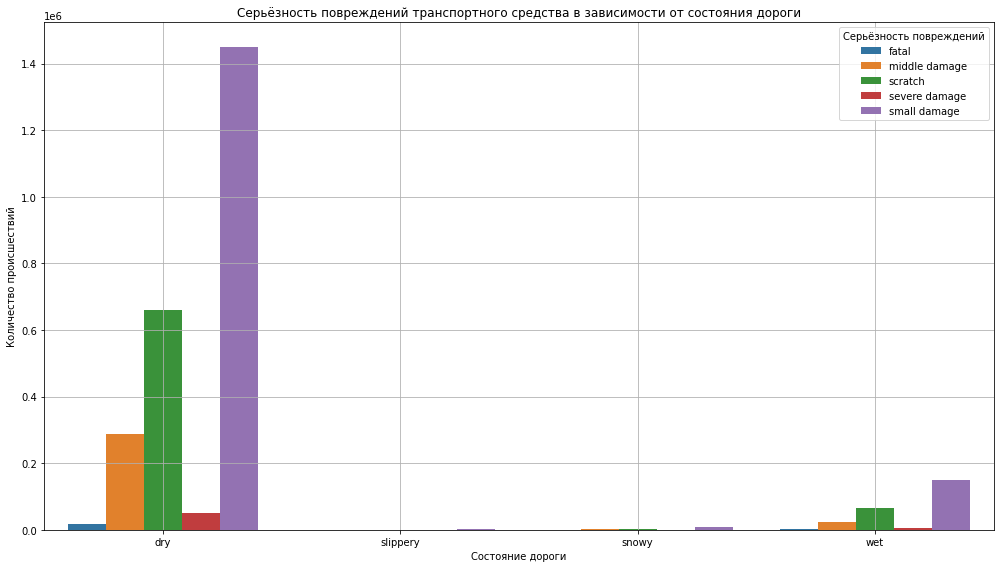

In [20]:
# Построение графика
plt.figure(figsize=(14, 8))
sns.barplot(data=df1, x='road_surface', y='accident_count', hue='collision_damage')
plt.title('Серьёзность повреждений транспортного средства в зависимости от состояния дороги')
plt.xlabel('Состояние дороги')
plt.ylabel('Количество происшествий')
plt.legend(title='Серьёзность повреждений')
plt.grid(True)
plt.tight_layout()
plt.show()

Основные результаты анализа:

    - Большинство аварий происходят на дорогах с сухим покрытием (Dry).
    - Сухие дороги (категория Dry) имеют наибольшее количество происшествий с разными уровнями повреждений (от мелких до серьёзных).
    
    
Возможные причины:

    - Высокая частота использования дорог: Сухие дороги, вероятно, чаще используются, так как они представляют собой нормальные условия в хорошую погоду. Вследствие этого количество аварий на них может быть выше.
    - Скоростной режим: Водители могут быть склонны к превышению скорости на сухих дорогах, что увеличивает вероятность возникновения аварий.
    - Количество транспорта: Высокая плотность транспортного потока на сухих дорогах также может быть фактором, способствующим увеличению числа аварий.

**Задача 2: Найти самые частые причины ДТП**

Порядок решения:

- Создать SQL-запрос:            
    - Выбрать столбец PRIMARY_COLL_FACTOR из таблицы collisions и подсчитать количество происшествий для каждой категории нарушений.
    - Отсортировать результаты по количеству происшествий в убывающем порядке.
- Построить графики:

    - Показать распределение количества происшествий по категориям нарушений.
- Сделать выводы

  primary_collision_factor  accident_count
0   vehicle code violation         1316453
1                  unknown           37014
2        other than driver           29780
3   other improper driving            8470
4                     None            8166


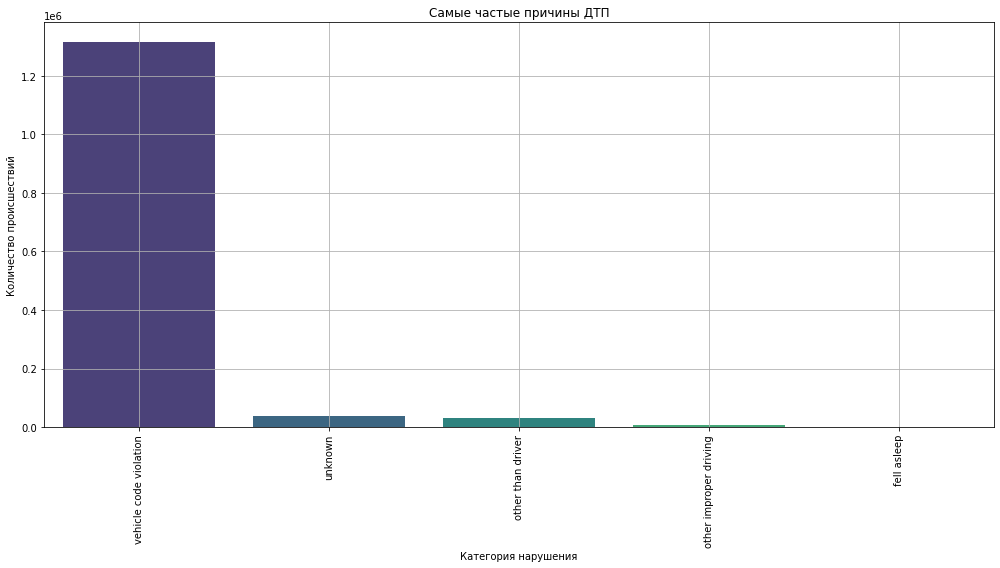

In [21]:
query = '''
SELECT 
    primary_collision_factor,
    COUNT(*) AS accident_count
FROM 
    collisions
GROUP BY 
    primary_collision_factor
ORDER BY 
    accident_count DESC;
'''

# Выполнение запроса и загрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)
print(df.head())

# Построение графика
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='primary_collision_factor', y='accident_count', palette='viridis')
plt.title('Самые частые причины ДТП')
plt.xlabel('Категория нарушения')
plt.ylabel('Количество происшествий')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

Основные результаты анализа:

- Наибольшее количество аварий связано с нарушением ПДД (code violation), что составляет подавляющее большинство всех происшествий (1,316,453 случаев).
- На втором месте по частоте указана категория unknown (неизвестно), с числом происшествий 37,014.
- Категория other than driver (другие участники, кроме водителя) также занимает значительное место, с 29,780 случаями.
- Другие причины включают other improper driving (другое неправильное вождение) с 8,470 случаями и None (без указания причины) с 8,166 случаями.


Возможные причины:

- Нарушение правил ПДД: Высокая частота ДТП, связанных с нарушением правил дорожного движения, может указывать на недостаточную дисциплину водителей и необходимость усиления контроля за соблюдением правил.
- Неизвестные причины: Высокое число случаев с причиной unknown может свидетельствовать о недостаточности данных или проблемах с регистрацией происшествий.
- Прочие участники: Категория other than driver включает случаи, где причиной происшествия являются другие участники (например, пешеходы, велосипедисты), что указывает на необходимость более тщательного анализа этих ситуаций.
- Неправильное вождение: Категория other improper driving указывает на случаи неправильного поведения водителей, не попадающие под другие категории.

**Вывод:**
- Провели статистический анализ факторов ДТП
- Выяснили, в какие месяцы происходит наибольшее количество аварий. Проанализировали весь период наблюдений (таблица collisions).

- Для совещания нашей рабочей группы, создали  подходящие аналитические задачи и поручили их решение коллегам.

- Провели анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связали collisions и parties);
- Нашли самые частые причины ДТП (таблица collisions).


## Модель для оценки водительского риска

Подготовим набор данных на основе первичного предположения заказчика:
 
- Выберем тип виновника — только машина (car).
- Возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмем данные только за 2012 год.


Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

In [22]:
# SQL-запрос для подготовки набора данных
query = '''
SELECT *
  FROM parties AS p
       FULL JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
       FULL JOIN collisions AS c ON p.case_id = c.case_id
 WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''

# Выполнение запроса и загрузка данных в DataFrame
data = pd.read_sql_query(query, con=engine)

In [23]:
data.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,2685660,5615920,4,car,0,NaN,impairment unknown,G,0.0,NaN,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-20,14:20:00
1,2694824,5620786,5,car,0,35.0,had not been drinking,None,0.0,NaN,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,obstruction,daylight,none,2012-04-26,07:30:00
2,2748517,5666312,5,car,0,37.0,had not been drinking,None,0.0,NaN,...,vehicle code violation,improper turning,hit object,fixed object,wet,normal,None,none,2012-05-02,04:40:00
3,2541014,5527313,5,car,0,45.0,had not been drinking,None,0.0,1399404.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-03-16,16:55:00
4,2541536,5527572,5,car,0,38.0,had not been drinking,None,0.0,NaN,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-03-08,06:30:00


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           196837 non-null  int64  
 1   case_id                      196837 non-null  object 
 2   party_number                 196837 non-null  int64  
 3   party_type                   196837 non-null  object 
 4   at_fault                     196837 non-null  int64  
 5   insurance_premium            176607 non-null  float64
 6   party_sobriety               193212 non-null  object 
 7   party_drug_physical          25148 non-null   object 
 8   cellphone_in_use             171464 non-null  float64
 9   id                           56248 non-null   float64
 10  case_id                      56248 non-null   object 
 11  party_number                 56248 non-null   float64
 12  vehicle_type                 56248 non-null   object 
 13 

In [25]:
data.describe()

,id,party_number,at_fault,insurance_premium,cellphone_in_use,id,party_number,vehicle_age,distance,intersection,party_count
count,1.968370e+05,196837.000000,196837.000000,176607.000000,171464.000000,5.624800e+04,56248.000000,54554.000000,1.968370e+05,195850.000000,196837.000000
mean,2.589799e+06,1.507745,0.523514,38.945002,0.023632,1.429235e+06,1.527432,4.856472,6.624782e+02,0.201899,2.106093
std,9.756972e+04,0.665083,0.499448,16.230328,0.151899,5.439976e+04,0.662507,3.234503,7.915264e+03,0.401419,0.726720
min,1.687780e+06,1.000000,0.000000,0.000000,0.000000,9.855270e+05,1.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,2.511773e+06,1.000000,0.000000,25.000000,0.000000,1.386473e+06,1.000000,3.000000,1.000000e+01,0.000000,2.000000
50%,2.593207e+06,1.000000,1.000000,36.000000,0.000000,1.432047e+06,1.000000,4.000000,1.000000e+02,0.000000,2.000000
75%,2.673872e+06,2.000000,1.000000,50.000000,0.000000,1.476086e+06,2.000000,7.000000,5.000000e+02,0.000000,2.000000
max,2.752408e+06,10.000000,1.000000,105.000000,1.000000,1.517653e+06,9.000000,161.000000,1.584000e+06,1.000000,12.000000


Проведем первичный отбор факторов, необходимых для модели:

- Изучим описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. 


- Пример:

`columms =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
           ......
         ]`


| Column                      | Описание                                      | Обоснование                                                                                                                                                             | Действие      |
|-----------------------------|-----------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|
| id                          | Уникальный номер                              | Не влияет на вероятность ДТП                                                                                                                                            | Удалить       |
| case_id                     | Номер случая                                  | Не влияет на вероятность ДТП                                                                                                                                            | Удалить       |
| party_number                | Номер участника                               | Не влияет на вероятность ДТП                                                                                                                                            | Удалить       |
| party_type                  | Тип участника                                 | Мы брали только машины, не влияет                                                                                                                                      | Удалить       |
| at_fault                    | Виновность участника                          | Может влиять на тяжесть и последствия ДТП, наш целевой признак                                                                                                                               | Оставить      |
| insurance_premium           | Сумма страховки                               | Может быть косвенным индикатором стоимости автомобиля и, соответственно, его вероятности участия в ДТП                                                                  | Оставить      |
| party_sobriety              | Уровень трезвости виновника                   | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| party_drug_physical         | Состояние участника (под воздействием)        | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| cellphone_in_use            | Использование телефона                        | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| vehicle_type                | Тип автомобиля                                | Может влиять на вероятность и тяжесть ДТП                                                                                                                               | Оставить      |
| vehicle_transmission        | Тип КПП                                        | Возможно влияет на вероятность ДТП (например, менее опытные водители могут избегать механической КПП)                                                                          | Оставить      |
| vehicle_age                 | Возраст автомобиля                            | Может влиять на вероятность ДТП (старые автомобили могут быть менее безопасны)                                                                                           | Оставить      |
| county_city_location        | Местоположение                                | Может влиять на вероятность ДТП (разные районы могут иметь разные условия)                                                                                              | Оставить      |
| county_location             | Название района                               | Дублирует `county_city_location`                                                                                                                                         | Удалить       |
| distance                    | Расстояние от главной дороги                  | Может влиять на вероятность ДТП                                                                                                                                         | Оставить      |
| direction                   | Направление движения                          | Может влиять на вероятность ДТП                                                                                                                                         | Оставить      |
| intersection                | Является ли место происшествия перекрестком   | Может влиять на вероятность ДТП                                                                                                                                         | Оставить      |
| weather_1                   | Погода                                        | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| location_type               | Тип дороги                                    | Может влиять на вероятность ДТП                                                                                                                                         | Оставить      |
| collision_damage            | Серьезность повреждений                       | Не влияет на вероятность ДТП, скорее на последствия                                                                                                                     | Удалить       |
| party_count                 | Количество участников                         | Может влиять на вероятность ДТП (больше участников - больше вероятность)                                                                                                 | Оставить      |
| primary_collision_factor    | Основной фактор аварии                        | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| pcf_violation_category      | Категория нарушения                           | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| type_of_collision           | Тип аварии                                    | Может влиять                                                                                                                         | Оставить       |
| motor_vehicle_involved_with | Взаимодействие с другим ТС или объектом       | Влияет                                                                                                                         | Оставить       |
| road_surface                | Состояние дороги                              | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| road_condition_1            | Состояние дороги                              | Тоже влияет                                                                                                                                               | Оставить       |
| lighting                    | Освещение                                     | Прямо влияет на вероятность ДТП                                                                                                                                         | Оставить      |
| control_device              | Устройство управления                         | Может влиять на вероятность ДТП                                                                                                                                         | Оставить      |
| collision_date              | Дата происшествия                             | Объяснено другими столбцами                                                                                              | Удалить      |
| collision_time              | Время происшествия                            | Объяснено другими столбцами                                                                                                                                           | Удалить      |


In [26]:
data.drop(columns=[
    'case_id', 'id', 'party_number', 'collision_damage', 'county_location', 'collision_date', 'collision_time', 'party_type'
], inplace=True, errors='ignore')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     196837 non-null  int64  
 1   insurance_premium            176607 non-null  float64
 2   party_sobriety               193212 non-null  object 
 3   party_drug_physical          25148 non-null   object 
 4   cellphone_in_use             171464 non-null  float64
 5   vehicle_type                 56248 non-null   object 
 6   vehicle_transmission         55389 non-null   object 
 7   vehicle_age                  54554 non-null   float64
 8   county_city_location         196837 non-null  object 
 9   distance                     196837 non-null  float64
 10  direction                    153975 non-null  object 
 11  intersection                 195850 non-null  float64
 12  weather_1                    196183 non-null  object 
 13 

Проведем статистическое исследование отобранных факторов.

In [28]:
# Статистическое описание категориальных данных
print("Статистическое описание категориальных данных:")
data.describe(include=['object'])

Статистическое описание категориальных данных:


,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,county_city_location,direction,weather_1,location_type,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device
count,193212,25148,56248,55389,196837,153975,196183,87357,196098,193173,195280,196000,195564,195694,196116,195864
unique,6,5,3,2,513,4,7,3,5,22,7,9,4,8,5,4
top,had not been drinking,G,sedan,manual,1942,north,clear,highway,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
freq,157684,20525,37180,29318,23010,42980,157335,71914,186926,69309,76645,147291,175564,189563,136370,132665


In [29]:
# Статистическое описание числовых данных
print("Статистическое описание числовых данных:")
data.describe()

Статистическое описание числовых данных:


,at_fault,insurance_premium,cellphone_in_use,vehicle_age,distance,intersection,party_count
count,196837.000000,176607.000000,171464.000000,54554.000000,1.968370e+05,195850.000000,196837.000000
mean,0.523514,38.945002,0.023632,4.856472,6.624782e+02,0.201899,2.106093
std,0.499448,16.230328,0.151899,3.234503,7.915264e+03,0.401419,0.726720
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,0.000000,25.000000,0.000000,3.000000,1.000000e+01,0.000000,2.000000
50%,1.000000,36.000000,0.000000,4.000000,1.000000e+02,0.000000,2.000000
75%,1.000000,50.000000,0.000000,7.000000,5.000000e+02,0.000000,2.000000
max,1.000000,105.000000,1.000000,161.000000,1.584000e+06,1.000000,12.000000


Проверка пропущенных значений:
    
- Определим количество пропущенных значений в каждом столбце.

In [30]:
print("Количество пропущенных значений в каждом столбце:")
data.isnull().sum()

Количество пропущенных значений в каждом столбце:


at_fault                            0
insurance_premium               20230
party_sobriety                   3625
party_drug_physical            171689
cellphone_in_use                25373
vehicle_type                   140589
vehicle_transmission           141448
vehicle_age                    142283
county_city_location                0
distance                            0
direction                       42862
intersection                      987
weather_1                         654
location_type                  109480
party_count                         0
primary_collision_factor          739
pcf_violation_category           3664
type_of_collision                1557
motor_vehicle_involved_with       837
road_surface                     1273
road_condition_1                 1143
lighting                          721
control_device                    973
dtype: int64

Анализ распределения признаков

- Построим гистограммы для числовых признаков и столбчатые диаграммы для категориальных признаков.

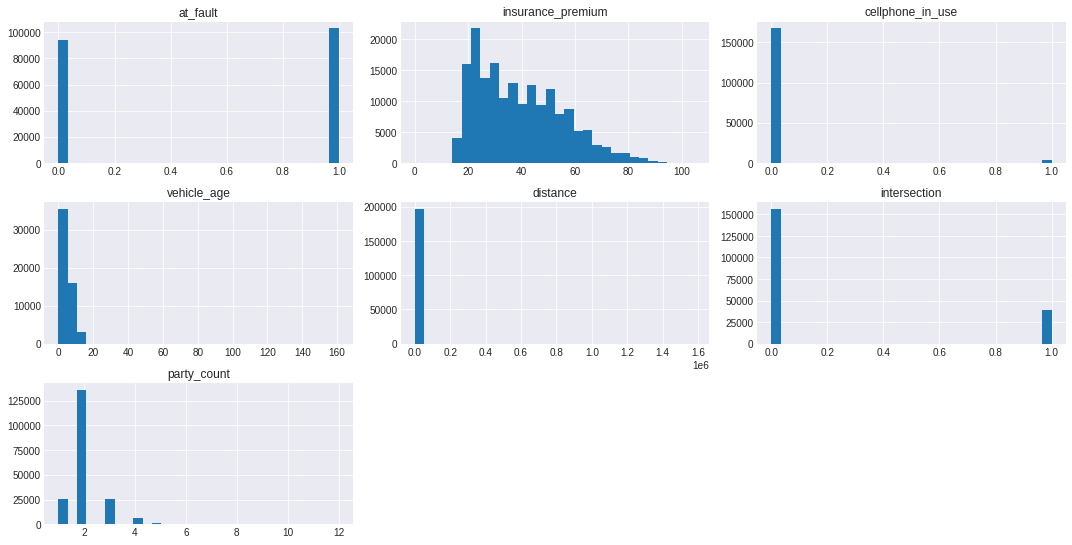

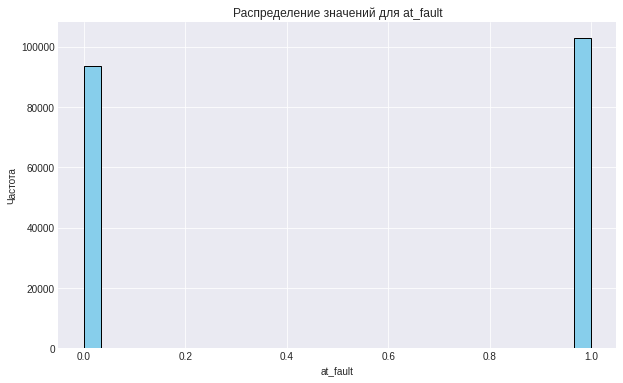

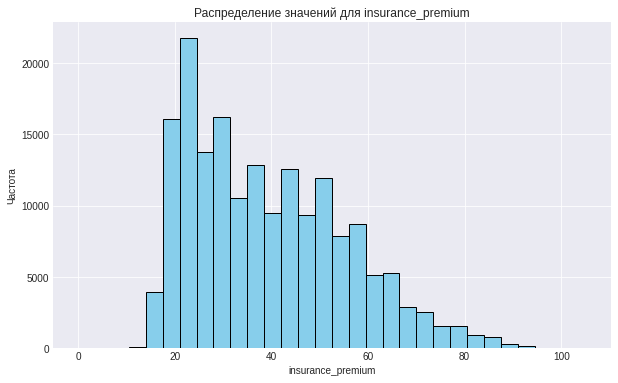

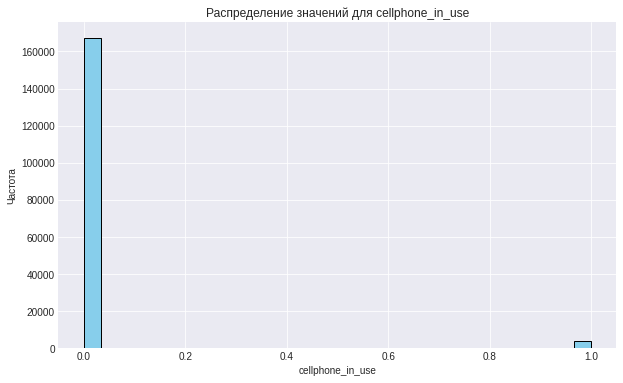

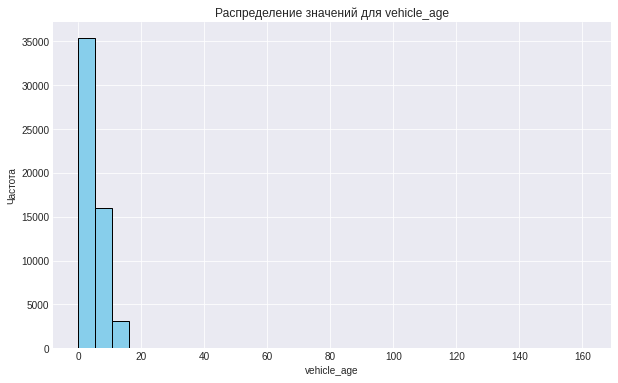

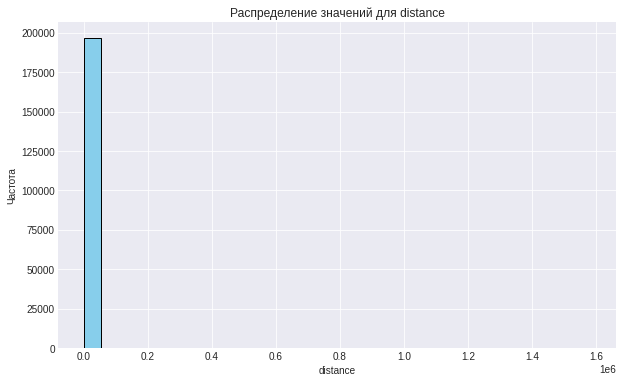

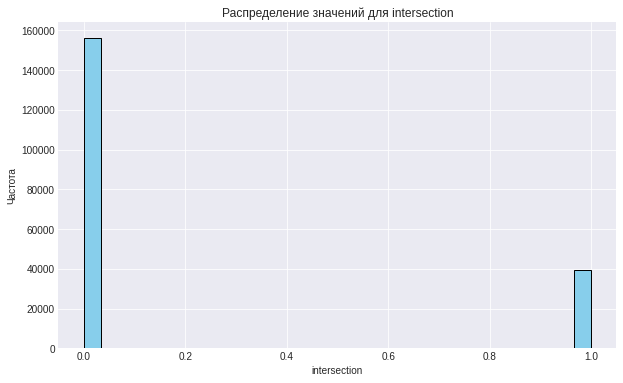

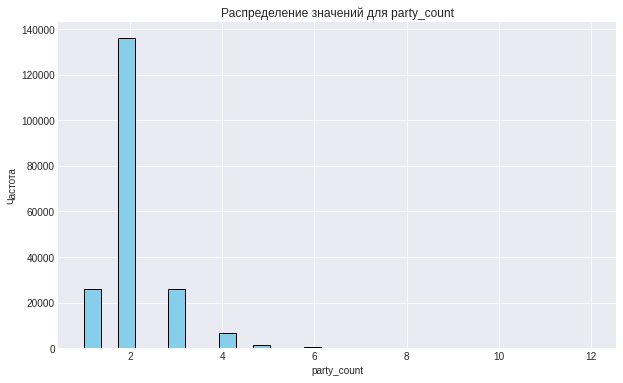

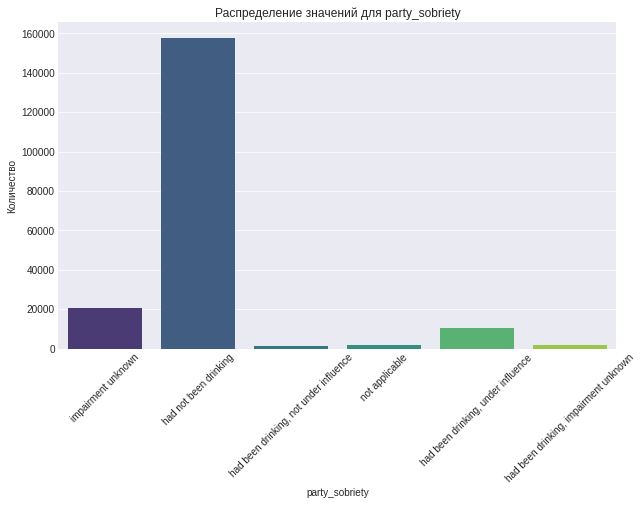

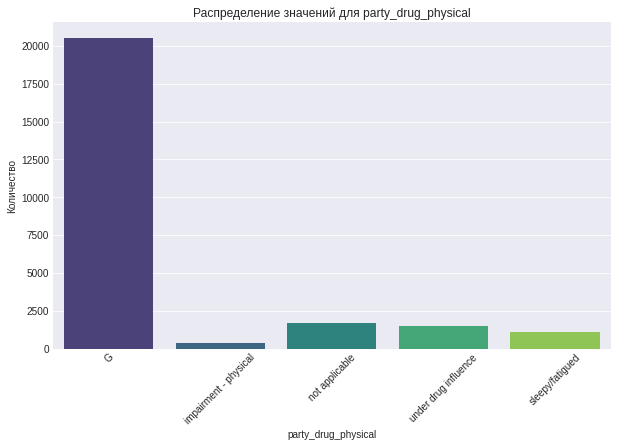

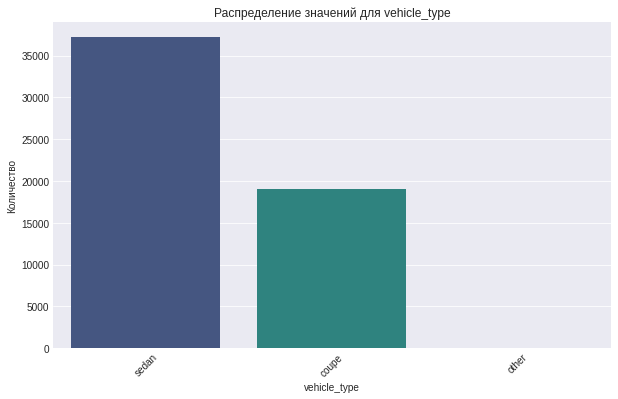

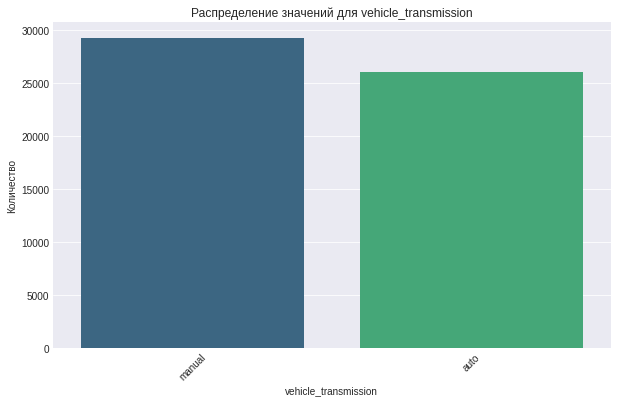

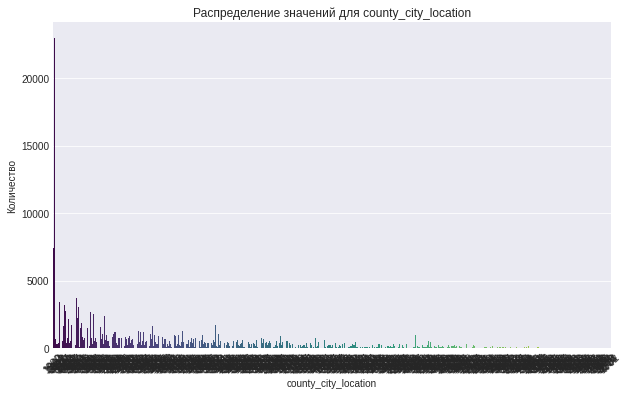

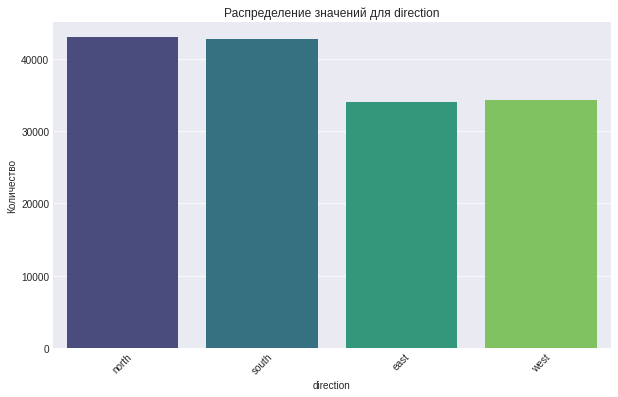

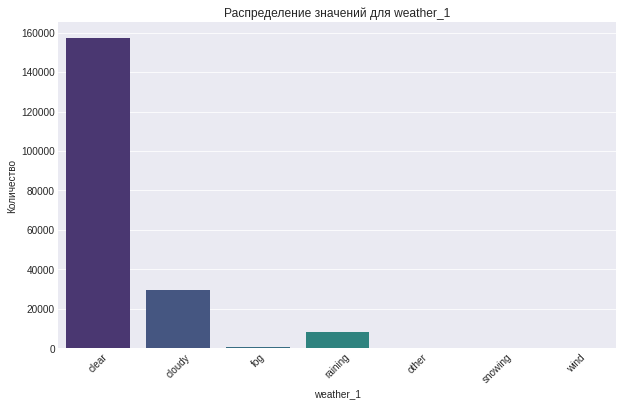

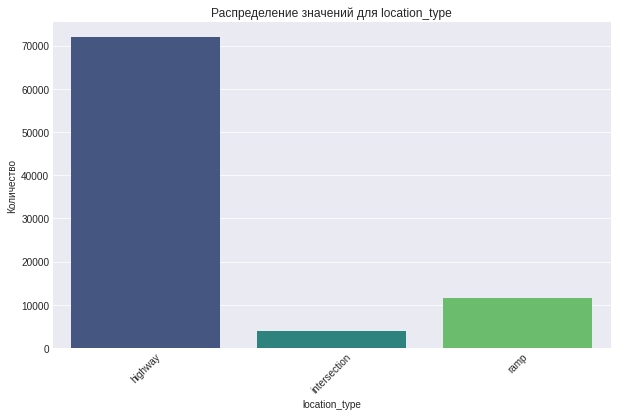

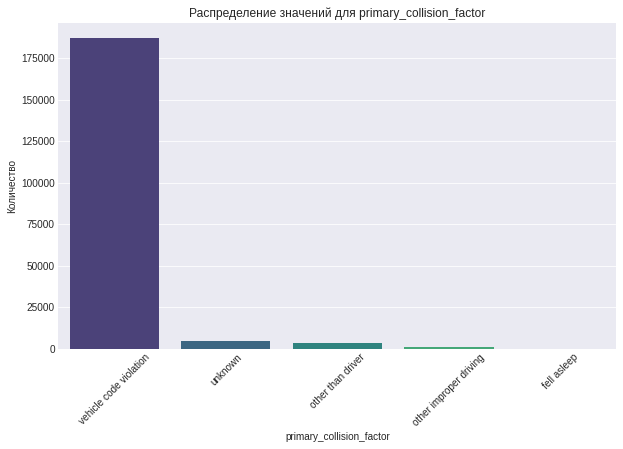

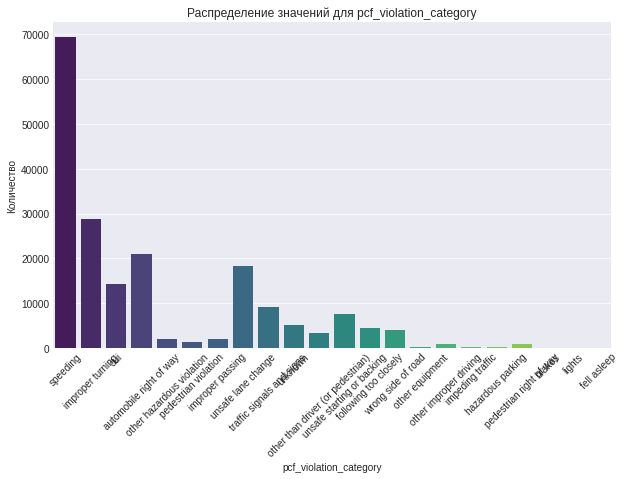

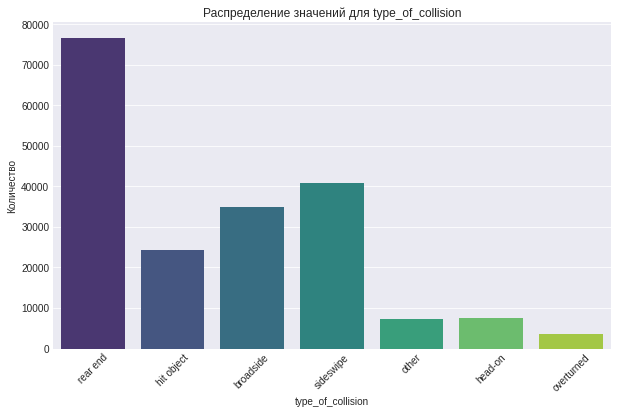

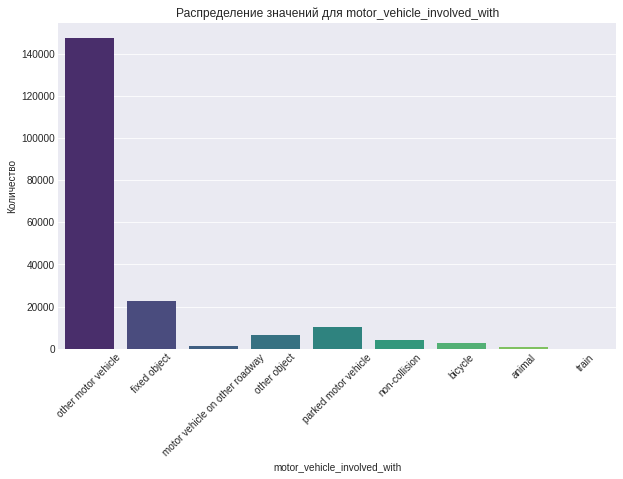

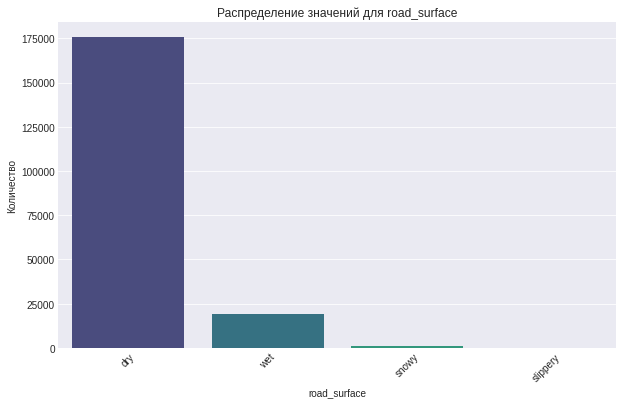

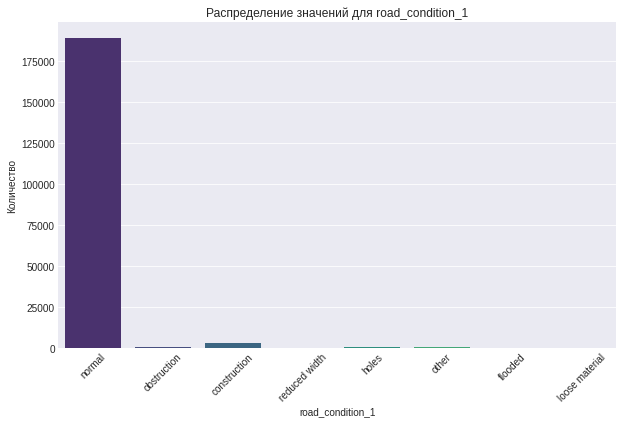

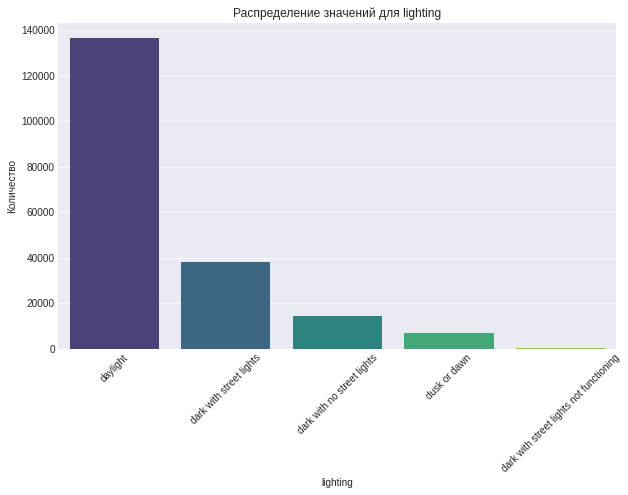

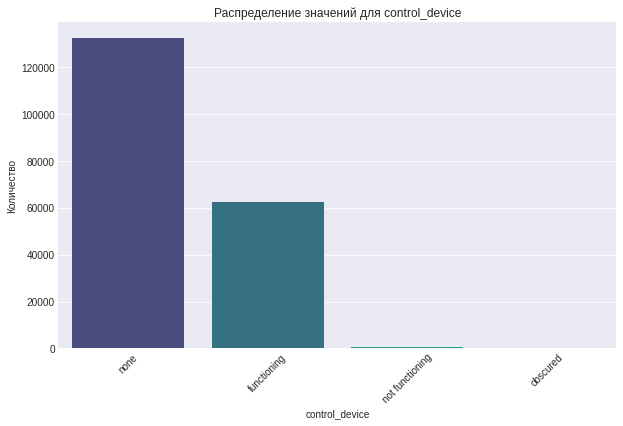

In [31]:
# Настройка визуализации
plt.style.use('seaborn-darkgrid')

# Числовые признаки
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Гистограммы для числовых признаков
data[numeric_columns].hist(bins=30, figsize=(15, 10), layout=(4, 3))
plt.tight_layout()
plt.show()

# Гистограммы для числовых признаков с подписями осей
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.title(f'Распределение значений для {col}')
    plt.show()

# Категориальные признаки
categorical_columns = data.select_dtypes(include=['object']).columns

# Столбчатые диаграммы для категориальных признаков
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=col, palette='viridis')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.title(f'Распределение значений для {col}')
    plt.show()

Проверка на выбросы

- Для числовых признаков построим "ящики с усами" (boxplots), чтобы выявить возможные выбросы.

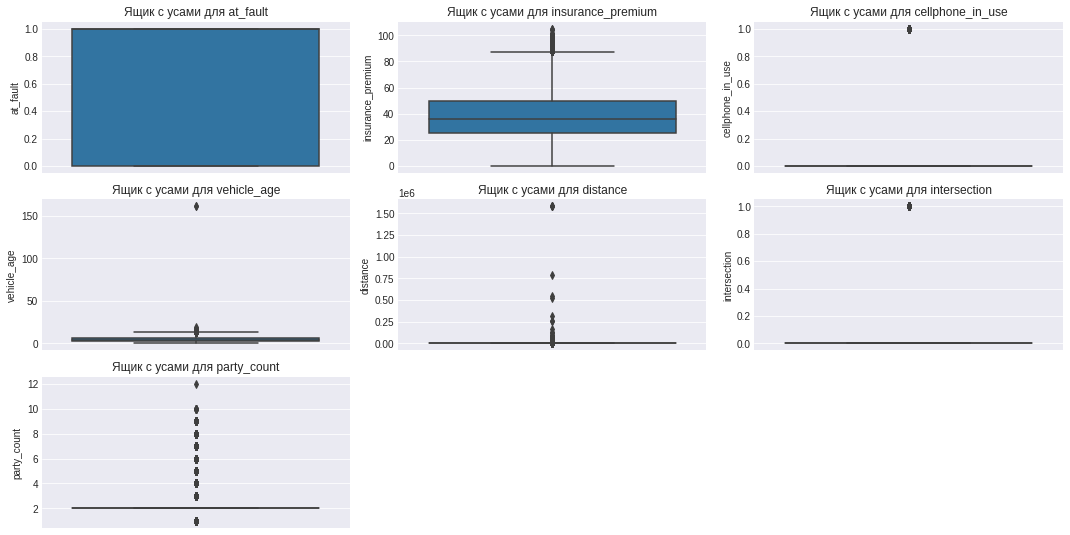

In [32]:
# Построение "ящиков с усами" для числовых признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=data, y=col)
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

**Вывод по EDA признаков:**


- insurance_premium:

    - Распределение страховок  имеет правый перекос, с большинством значений, сосредоточенных в диапазоне от 20 до 60.
    
    
- distance:

    - Распределение расстояний также имеет правый перекос, с небольшим количеством выбросов, превышающих 1 000 000.
    
    
- party_count:

    - Большинство аварий происходит с участием двух сторон, в то время как случаи с участием более двух сторон встречаются реже.
    
    
- vehicle_age:

    - Возраст транспортных средств в большинстве случаев сосредоточен в диапазоне до 20 лет. Выбросы, превышающие 150 лет, могут указывать на ошибки в данных.
    
    
- party_drug_physical:

    - Большинство участников аварий были трезвыми (категория G). Остальные категории представлены в значительно меньших количествах.
    
    
- vehicle_type:

    - Наиболее распространенные типы транспортных средств в данных - седаны, за ними следуют купе. Другие типы представлены реже.
    
    
- vehicle_transmission:

    - Распределение типов трансмиссий автомобилей практически равное между автоматическими и механическими коробками передач.
    
    
- direction:

    - Наиболее часто встречающиеся направления движения - север и юг, за ними следуют восток и запад.
    
    
- weather_1:

    - Большинство аварий происходит при ясной погоде. Дождь и облачность встречаются реже.
    
    
- location_type:

    - Большинство аварий происходит на шоссе, затем следуют перекрестки и съезды.
    
    
- primary_collision_factor:

    - Наиболее частая причина аварий - нарушение правил дорожного движения. Остальные факторы встречаются значительно реже.
    
    
- pcf_violation_category:

    - Наиболее частое нарушение - превышение скорости. Другие категории нарушений, такие как вождение в нетрезвом виде и неправильные повороты, встречаются реже.
    
    
- type_of_collision:

    - Наиболее распространенные типы столкновений - удары сзади, боковые удары и удары сбоку.
    
    
- road_surface:

    - Большинство аварий происходит на сухой дороге. Мокрые, снежные и скользкие поверхности встречаются реже.
    
    
- control_device:

    - Большинство аварий происходит в отсутствие управляющего устройства. Функционирующие устройства встречаются реже.


- at_fault:

    - Значения распределены равномерно между 0 и 1. Поскольку это бинарный признак, boxplot здесь не слишком информативен.
    
    
- insurance_premium:

    - Большинство значений страховой премии лежит в пределах от 20 до 60, с медианой около 40.
    - Присутствует несколько выбросов, превышающих 100.
    
    
- cellphone_in_use:

    - Большинство значений равно 0, указывая, что в большинстве случаев телефон не использовался.
    - Присутствуют единичные случаи использования телефона, что может быть связано с потенциальной причиной ДТП.
    
    
- vehicle_age:

    - Большинство автомобилей имеют возраст менее 20 лет.
    - Есть несколько выбросов с возрастом автомобилей, превышающим 50 лет, что может свидетельствовать о старых автомобилях, участвовавших в ДТП.
    
    
- distance:

    - Распределение значений расстояния сильно смещено в сторону меньших значений.
    - Присутствует множество значительных выбросов, превышающих 1 миллион, что может быть результатом ошибок в данных или редких, но очень длинных поездок.
    
    
- intersection:

    - Большинство значений равно 0, указывая, что в большинстве случаев аварии происходили не на перекрестках.
    - Присутствует несколько значений, равных 1, указывая на аварии на перекрестках.
    
    
- party_count:

    - Большинство случаев включает 2 участников.
    - Присутствуют несколько выбросов с большим количеством участников (до 12), что может свидетельствовать о крупных авариях с участием нескольких транспортных средств.
    
    

- В столбцах distance и vehicle_age есть экстремальные значения

- Столбец direction содержит категориальные данные и имеет много пропусков

- В столбце location_type много пропусков. Судя по остальным категориям, оставшиеся значения можно отнести к авариям на дороге.

- В столбцах primary_collision_factor и pcf_violation_category есть пропуски и категория unknown. 

- В столбце party_sobriety есть категория impairment unknown и пропущенные значения. 

- Аналогично в столбце party_drug_physical много пропусков, но есть категория G (impairment unknown). П

- В столбце vehicle_type есть 4 значения other. 

- Аналогично, в столбце vehicle_transmission с пропусками. 

- Нет категории unknown для значений в столбце cellphone_in_use.

Анализ корреляции между признаками
- Построим матрицу корреляций для признаков и визуализируем ее с помощью тепловой карты (heatmap).

In [33]:
# # Матрица корреляций
# correlation_matrix = data[numeric_columns].corr()

# # Визуализация матрицы корреляций с помощью тепловой карты
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Матрица корреляций')
# plt.show()

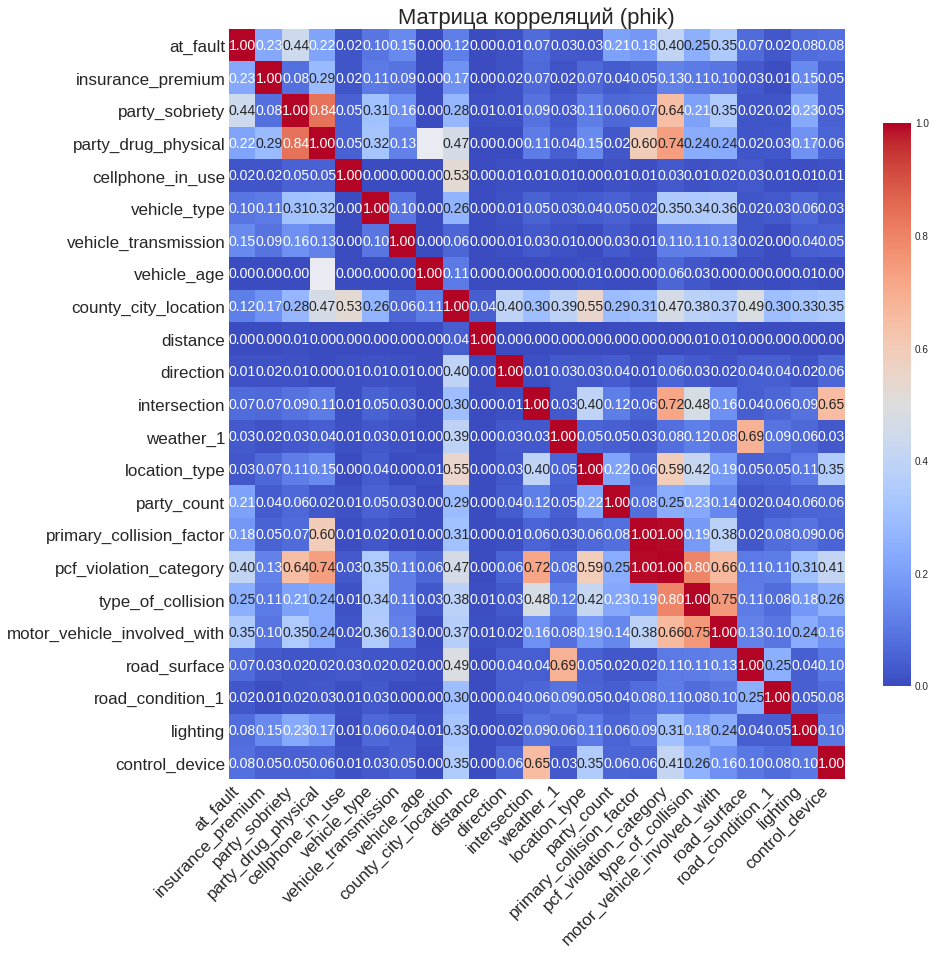

In [34]:
# Определение списка непрерывных признаков
continuous_features = numeric_columns.tolist()

# Построение матрицы корреляций phik
phik_matrix = data.phik_matrix(interval_cols=continuous_features)

# Визуализация матрицы корреляций phik с помощью тепловой карты
num_features = len(phik_matrix.columns)
figsize = (num_features * 0.6, num_features * 0.6) 

plt.figure(figsize=figsize)
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 14}, cbar_kws={'shrink': .75})
plt.title('Матрица корреляций (phik)', size=22)
plt.xticks(rotation=45, ha='right', size=17)
plt.yticks(rotation=0, size=17)
plt.show()

Корреляционная матрица показывает силу и направление взаимосвязи между различными признаками в датасете. В данной матрице используются цветовые коды для представления значений корреляции: от темно-синего (отсутствие корреляции) до красного (сильная положительная корреляция).

Общие наблюдения:

- Диагональные элементы:

    - Все значения на диагонали равны 1.0, что логично, так как каждый признак полностью коррелирован с самим собой.
    
    
- Есть признаки с высокой корреляцией, например:

    - Сильная взаимосвязь между трезвостью участников и наличием физического воздействия наркотиков или алкоголя.
    - Сильная корреляция между категорией нарушения ПДД и основным фактором столкновения.
    - Высокая корреляция между типом столкновения и категорией нарушения ПДД.
    - Значительная корреляция между вовлеченными транспортными средствами и категорией нарушения ПДД.
    - Заметная связь между состоянием дорожного покрытия и освещением.
    - и т.д.
    
    
- И есть признаки с умеренной корреляцией, например:

    - Умеренная корреляция между устройствами управления движением и состоянием дорожного покрытия.
    - и т.д.
    
    
    
    
    
- **НО!** большинство признаков имеют низкую корреляцию между собой, что указывает на слабую взаимосвязь или ее отсутствие.

Проверка на дубликаты
- Проверим, есть ли в данных дубликаты, и при необходимости удалим их.

In [35]:
# Проверка на дубликаты
duplicate_rows = data[data.duplicated()]
print(f"Количество дубликатов в данных: {duplicate_rows.shape[0]}")

# Если дубликаты найдены, удалить их
if duplicate_rows.shape[0] > 0:
    data = data.drop_duplicates()
    print("Дубликаты удалены.")
else:
    print("Дубликатов не найдено.")

Количество дубликатов в данных: 1572
Дубликаты удалены.


Переименуем столбцы в соответствии со стандратом:

In [36]:
data = data.copy()
data.rename(columns={'weather_1':'weather', 'road_condition_1':'road_condition'}, inplace=True)

**Предложения по обработке данных**

- Удаление экстремальных значений:

    - Удалить экстремальные значения в столбцах distance и vehicle_age.
    
    
- Обработка пропущенных значений в столбце direction:

    - Поскольку столбец direction содержит категориальные данные и имеет много пропусков, добавить дополнительную категорию unknown для заполнения пропущенных значений.
    
    
- Обработка пропущенных значений в столбце location_type:

    - В столбце location_type много пропусков. Судя по остальным категориям, оставшиеся значения можно отнести к авариям на дороге, поэтому заполнить пропуски категорией road.
    
    
- Обработка пропущенных значений в столбцах primary_collision_factor и pcf_violation_category:

    - В этих столбцах есть пропуски и категория unknown. Заполнить пропуски значением unknown.
    
    
- Заполнение пропущенных значений в столбце insurance_premium:

    - Использовать Imputer для заполнения пропусков в столбце insurance_premium.
    
    
- Обработка пропущенных значений в столбце party_sobriety:

    - В столбце party_sobriety есть категория impairment unknown. Заполнить пропуски значением impairment unknown.
    
    
- Обработка пропущенных значений в столбце party_drug_physical:

    - В столбце party_drug_physical много пропусков, но есть категория G (impairment unknown). Переименовать категорию G в impairment unknown и заполнить пропуски этим значением.
    
    
- Обработка пропущенных значений в столбцах vehicle_type и vehicle_transmission:

    - В столбце vehicle_type есть 4 значения other. Удалить эти значения и заполнить пропуски значением unknown.
    - Аналогично, в столбце vehicle_transmission заполнить пропуски значением unknown.
    
    
- Заполнение пропущенных значений в столбце vehicle_age:

    - Использовать Imputer для заполнения пропусков в столбце vehicle_age.
    

- Обработка пропущенных значений в столбце cellphone_in_use:

    - Добавить категорию unknown для заполнения пропусков в столбце cellphone_in_use.

In [37]:
# # Удаление экстремальных значений
# data.drop(index=data[data['distance'] > data['distance'].quantile(0.99)].index, inplace=True)
# data.drop(index=data[data['vehicle_age'] > data['vehicle_age'].quantile(0.99)].index, inplace=True)

In [38]:
# Обработка пропущенных значений в столбце direction
data['direction'].fillna('unknown', inplace=True)

# Обработка пропущенных значений в столбце location_type
data['location_type'].fillna('road', inplace=True)

# Обработка пропущенных значений в столбцах primary_collision_factor и pcf_violation_category
data['primary_collision_factor'].fillna('unknown', inplace=True)
data['pcf_violation_category'].fillna('unknown', inplace=True)

# # Заполнение пропущенных значений в столбце insurance_premium
# imputer = SimpleImputer(strategy='mean')
# data['insurance_premium'] = imputer.fit_transform(data[['insurance_premium']])

In [39]:
# Обработка пропущенных значений в столбце party_sobriety
data['party_sobriety'].fillna('impairment unknown', inplace=True)

# Обработка пропущенных значений в столбце party_drug_physical
data['party_drug_physical'] = data['party_drug_physical'].replace('G', 'impairment unknown')
data['party_drug_physical'].fillna('impairment unknown', inplace=True)

# Обработка пропущенных значений в столбцах vehicle_type и vehicle_transmission
data = data[data['vehicle_type'] != 'other']
data['vehicle_type'].fillna('unknown', inplace=True)
data['vehicle_transmission'].fillna('unknown', inplace=True)

# Обработка пропущенных значений в столбце cellphone_in_use
data['cellphone_in_use'].fillna('unknown', inplace=True)

Преобразуем типы данных:

In [40]:
numeric = [
    'at_fault', 'insurance_premium', 'distance', 'party_count', 'vehicle_age'
]

category = [
    'party_sobriety', 'party_drug_physical',
    'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
    'county_city_location', 'direction',
    'intersection', 'weather', 'location_type', 'primary_collision_factor', 'pcf_violation_category',
    'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
    'road_condition', 'lighting', 'control_device'
]

data[numeric] = data[numeric].fillna(data[numeric].mean())

# Преобразование числовых столбцов в int
data[numeric] = data[numeric].astype(int)

# Преобразование категориальных столбцов в категориальные
for col in category:
    data[col] = data[col].astype('category')

Посмотрим на конечный результат:

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195261 entries, 0 to 196836
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   at_fault                     195261 non-null  int64   
 1   insurance_premium            195261 non-null  int64   
 2   party_sobriety               195261 non-null  category
 3   party_drug_physical          195261 non-null  category
 4   cellphone_in_use             195261 non-null  category
 5   vehicle_type                 195261 non-null  category
 6   vehicle_transmission         195261 non-null  category
 7   vehicle_age                  195261 non-null  int64   
 8   county_city_location         195261 non-null  category
 9   distance                     195261 non-null  int64   
 10  direction                    195261 non-null  category
 11  intersection                 194278 non-null  category
 12  weather                      194611 non-null

In [42]:
# Разделение данных на признаки и целевой признак
X = data.drop(columns=['at_fault'])
y = data['at_fault']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров выборок
train_size = X_train.shape[0]
test_size = X_test.shape[0]
total_size = data.shape[0]

print(f"Размер обучающей выборки: {train_size} записей ({train_size / total_size * 100:.2f}%)")
print(f"Размер тестовой выборки: {test_size} записей ({test_size / total_size * 100:.2f}%)")

Размер обучающей выборки: 156208 записей (80.00%)
Размер тестовой выборки: 39053 записей (20.00%)


**Вывод:**

- Подготовили набор данных на основе первичного предположения заказчика:
 
    - Выбрали тип виновника — только машина (car). 
    - Взяли случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
    - Для моделирования взяли данные только за 2012 год.
    - Подготовка исходной таблицы  проводилась с помощью sql-запроса.
    
    
- Провели первичный отбор факторов, необходимых для модели:
    - Изучили описание факторов. Отобрали те, которые могут влиять на вероятность ДТП. Аргументировали свой выбор. 

- Провели статистическое исследование отобранных факторов.
- По результату исследовательского анализа внесли корректировки и сделали вывод.
- Подготовили обучающую и тестовую выборки.

## Поиск лучшей модели

- Смоделируем не менее 3-х типов моделей с перебором гиперпараметров.
- Выберем метрику для оценки модели, исходя из поставленной бизнесом задачи. Обоснуем свой выбор.
- Оформим вывод в виде сравнительной таблицы.

- Для данной задачи будем использовать следующие модели: Logistic Regression, Random Forest, и Gradient Boosting.

- Выбор метрики:
    - Для оценки моделей используем метрику F1-score, так как она учитывает как точность (precision), так и полноту (recall). Это особенно важно в случаях, когда необходимо учитывать баланс, что может быть критично в задачах, связанных с безопасностью дорожного движения.

In [43]:
# Определение числовых и категориальных признаков
numeric_features = ['insurance_premium', 'distance', 'party_count', 'vehicle_age']
categorical_features = ['party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
                        'vehicle_transmission', 'county_city_location', 'direction', 'intersection', 'weather',
                        'location_type', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision',
                        'motor_vehicle_involved_with', 'road_surface', 'road_condition', 'lighting', 'control_device']

# Заполнение пропущенных значений в числовых признаках
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())

# Добавление новой категории 'unknown' и заполнение пропущенных значений в категориальных признаках
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    if 'unknown' not in X_train[col].cat.categories:
        X_train[col] = X_train[col].cat.add_categories('unknown')
    if 'unknown' not in X_test[col].cat.categories:
        X_test[col] = X_test[col].cat.add_categories('unknown')
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')

    X_test[col] = X_test[col].cat.set_categories(X_train[col].cat.categories)

# Преобразование всех категориальных значений в строки
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# Создание преобразователя для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Создание преобразователя для категориальных признаков
categorical_transformer_ohe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

categorical_transformer_oe = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Объединение преобразователей в ColumnTransformer
log_reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_ohe, categorical_features)
    ]
)

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer_oe, categorical_features)
    ]
)

gb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_oe, categorical_features)
    ]
)

In [44]:
# Определение моделей и их гиперпараметров
models = {
    'log_reg': {
        'model': Pipeline(steps=[
            ('preprocessor', log_reg_preprocessor),
            ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
        ]),
        'params': {
            'classifier__C': [0.1, 1.0],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'rf': {
        'model': Pipeline(steps=[
            ('preprocessor', rf_preprocessor),
            ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'gb': {
        'model': Pipeline(steps=[
            ('preprocessor', gb_preprocessor),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    }
}


# Обучение моделей и поиск гиперпараметров
results = {}
classification_reports = {}

for name, model_info in models.items():
    print(f"Начало GridSearchCV для модели: {name}")
    clf = GridSearchCV(model_info['model'], model_info['params'], scoring='f1', cv=5, n_jobs=-1, verbose=10)
    clf.fit(X_train, y_train)
    y_pred_cv = cross_val_predict(clf.best_estimator_, X_train, y_train, cv=5)
    classification_reports[name] = classification_report(y_train, y_pred_cv, output_dict=True)
    results[name] = {
        'f1_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_
    }
    joblib.dump(clf.best_estimator_, f'best_{name}_model.pkl')
    print(f"GridSearchCV завершен для модели: {name} с F1-score: {clf.best_score_:.4f}")
    print(f"Лучшие параметры для модели {name}: {clf.best_params_}")

# Сравнительная таблица результатов
results_df = pd.DataFrame({k: {'f1_score': v['f1_score'], 'best_params': v['best_params']} for k, v in results.items()}).T
print("Сравнительная таблица результатов:")
print(results_df)

# Найдем лучшую модель
results_df['f1_score'] = pd.to_numeric(results_df['f1_score'], errors='coerce')
best_model_name = results_df['f1_score'].idxmax()
best_model_f1 = results_df.loc[best_model_name, 'f1_score']
best_model_params = results_df.loc[best_model_name, 'best_params']

print(f'\nЛучшей моделью является {best_model_name} с F1-score: {best_model_f1:.4f}')
print(f'Лучшие гиперпараметры для модели {best_model_name}: {best_model_params}')

# Оценка лучшей модели на тестовой выборке
best_model = joblib.load(f'best_{best_model_name}_model.pkl')
y_pred_best = best_model.predict(X_test)
best_model_f1_test = f1_score(y_test, y_pred_best)
classification_report_best = classification_report(y_test, y_pred_best, output_dict=True)

# Сохранение предсказаний и результатов
best_model_info = {
    'model_name': best_model_name,
    'f1_score': best_model_f1,
    'f1_score_test': best_model_f1_test,
    'best_params': best_model_params,
    'predictions': y_pred_best,
    'classification_report': classification_report_best
}

joblib.dump(best_model_info, 'best_model_info.pkl')

# Сравнительная таблица с precision, recall, f1-score для всех моделей
comparison_df = pd.DataFrame({
    'Model': results_df.index,
    'Precision': [classification_reports[name]['weighted avg']['precision'] for name in results_df.index],
    'Recall': [classification_reports[name]['weighted avg']['recall'] for name in results_df.index],
    'F1-Score': [classification_reports[name]['weighted avg']['f1-score'] for name in results_df.index]
}).set_index('Model')

Начало GridSearchCV для модели: log_reg
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START classifier__C=0.1, classifier__penalty=l1...................
[CV 1/5; 1/4] END classifier__C=0.1, classifier__penalty=l1;, score=0.686 total time= 1.1min
[CV 2/5; 1/4] START classifier__C=0.1, classifier__penalty=l1...................
[CV 2/5; 1/4] END classifier__C=0.1, classifier__penalty=l1;, score=0.682 total time= 1.0min
[CV 3/5; 1/4] START classifier__C=0.1, classifier__penalty=l1...................
[CV 3/5; 1/4] END classifier__C=0.1, classifier__penalty=l1;, score=0.680 total time= 1.1min
[CV 4/5; 1/4] START classifier__C=0.1, classifier__penalty=l1...................
[CV 4/5; 1/4] END classifier__C=0.1, classifier__penalty=l1;, score=0.680 total time=  57.5s
[CV 5/5; 1/4] START classifier__C=0.1, classifier__penalty=l1...................
[CV 5/5; 1/4] END classifier__C=0.1, classifier__penalty=l1;, score=0.684 total time= 1.1min
[CV 1/5; 2/4] START classifier

In [45]:
print("Сравнительная таблица для каждой модели:")
comparison_df

Сравнительная таблица для каждой модели:


,Precision,Recall,F1-Score
Model,,,
log_reg,0.746604,0.718113,0.712977
rf,0.754291,0.727453,0.723002
gb,0.749868,0.735244,0.733376


In [46]:
# Вывод классификационного отчета для лучшей модели
print("Классификационный отчет для лучшей модели на тестовой выборке:")
report_df = pd.DataFrame(classification_report_best).transpose()
report_df

Классификационный отчет для лучшей модели на тестовой выборке:


,precision,recall,f1-score,support
0,0.674785,0.839761,0.748288,18541.000000
1,0.814068,0.634165,0.712943,20512.000000
accuracy,0.731775,0.731775,0.731775,0.731775
macro avg,0.744427,0.736963,0.730615,39053.000000
weighted avg,0.747942,0.731775,0.729723,39053.000000


**Вывод:**

**На основе сравнительной таблицы с метриками precision, recall и F1-score для каждой модели можно сделать следующие выводы:**


- Logistic Regression:
    - Вывод: Модель логистической регрессии имеет хороший баланс между precision и recall, что подтверждается высоким значением F1-score.



- Random Forest Classifier:
    - Вывод: Случайный лес демонстрирует чуть лучшие показатели по сравнению с логистической регрессией, что говорит о его способности лучше учитывать сложные взаимодействия между признаками.


- Gradient Boosting:
    - Вывод: Градиентный бустинг показывает наилучшие результаты среди всех моделей. Высокие значения precision и recall приводят к наивысшему F1-score, что делает эту модель наиболее эффективной для текущей задачи.



**Итог:**
- Лучшей моделью по результатам является Gradient Boosting, показывающая наивысший F1-score. Эта модель имеет сбалансированные показатели precision и recall, что делает её наиболее подходящей.

**На основании результатов, Gradient Boosting рекомендована для дальнейшего использования.**

## Проверка лучшей модели

- Проведем графический анализ «Матрица ошибок». 
- Выведем полноту и точность на график.
- Проанализируем важность основных факторов, влияющих на вероятность ДТП.

In [47]:
# Загрузка лучшей модели
best_model = joblib.load('best_gb_model.pkl')

**Матрица ошибок**

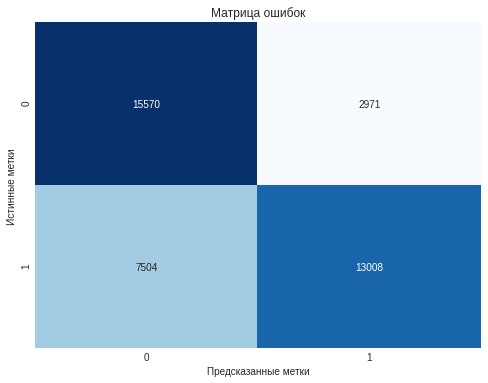

In [48]:
# Предсказания на тестовых данных
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

**График полноты и точности**

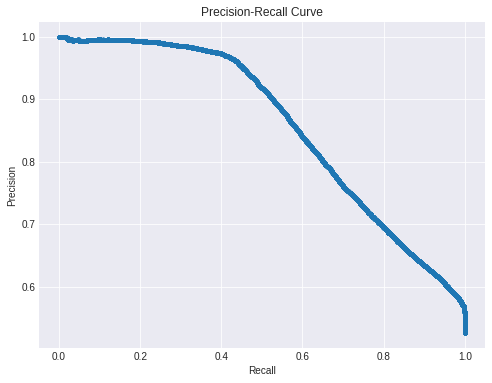

In [49]:
# Построение графика precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**На основе матрицы ошибок видно следующее:**

- Модель хорошо справляется с определением невиновных участников ДТП, но также имеет некоторую долю ошибок, когда невиновные были классифицированы как виновные.


- True Negative (TN) - Истинные отрицательные:

    - Верхняя левая ячейка: 15,570
    - Это количество случаев, когда модель правильно предсказала, что участник не виновен (реально не виновен).
    - Интерпретация: Модель смогла правильно определить 15,570 случаев, где участники ДТП действительно не были виновны. Это важный показатель для оценки надежности модели в выявлении невиновных.
    
    
- False Positive (FP) - Ложные положительные:

    - Верхняя правая ячейка: 2,971
    - Это количество случаев, когда модель предсказала, что участник виновен, но на самом деле он не виновен.
    - Интерпретация: Модель ошибочно классифицировала 2,971 невиновных участников как виновных. 
    
- False Negative (FN) - Ложные отрицательные:

    - Нижняя левая ячейка: 7,504
    - Это количество случаев, когда модель предсказала, что участник не виновен, но на самом деле он виновен.
    - Интерпретация: Модель не смогла определить вину в 7,504 случаях, где участники ДТП действительно были виновны. 
    
- True Positive (TP) - Истинные положительные:

    - Нижняя правая ячейка: 13,008
    - Это количество случаев, когда модель правильно предсказала, что участник виновен (реально виновен).
    - Интерпретация: Модель успешно идентифицировала 13,008 виновных участников. Это показатель эффективности модели в выявлении действительных виновников, что важно для точного анализа и принятия решений.
    
    
- Общая интерпретация:
    - Точность модели в определении невиновных (True Negative Rate):
        - Модель справляется с задачей идентификации невиновных участников в 15,570 случаях, но ошибается в 2,971 случае. Это может говорить о высокой чувствительности модели к невиновным.
    - Точность модели в определении виновных (True Positive Rate):
        - Модель успешно идентифицирует виновных участников в 13,008 случаях, но допускает 7,504 ошибки. Это показывает, что модель может улучшить точность в определении виновников.

- Кривая Precision-Recall (Точность-Полнота) предоставляет информацию о производительности модели в терминах точности и полноты, что особенно важно для задач классификации с несбалансированными классами.

- Точность (Precision):
    - Точность показывает, какой процент предсказанных положительных классов (виновных участников) действительно являются положительными (виновными). Высокая точность означает, что модель редко ошибается в определении невиновных как виновных.

- Полнота (Recall):
    - Полнота показывает, какой процент истинных положительных классов (виновных участников) был правильно идентифицирован моделью. Высокая полнота означает, что модель способна находить большинство виновных участников.

- Анализ кривой:
    - Начало кривой (слева):
     - Высокая точность (~1.0), низкая полнота. Это означает, что при низкой полноте (мало обнаруженных виновных) модель делает мало ошибок, классифицируя невиновных как виновных.
    
- Средняя часть кривой:
    - По мере увеличения полноты, точность постепенно снижается. Это типичный случай, когда увеличение числа найденных виновных участников приводит к небольшому увеличению ошибок, при которых невиновные классифицируются как виновные.
    
- Конец кривой (справа):
    - Высокая полнота (~1.0), низкая точность. Это означает, что модель нашла почти всех виновных участников, но также сделала много ошибок, классифицируя невиновных как виновных.
    
    
- Бизнес-Интерпретация:
    - Высокая точность:
        - Важно для минимизации ошибок при обвинении невиновных участников ДТП. Высокая точность снижает юридические и репутационные риски, связанные с неверным обвинением невиновных.
    - Высокая полнота:
        - Важно для уверенности в том, что большинство виновных участников будут выявлены. Это критично для справедливого распределения ответственности и предотвращения дальнейших нарушений.

**Анализ важности признаков**

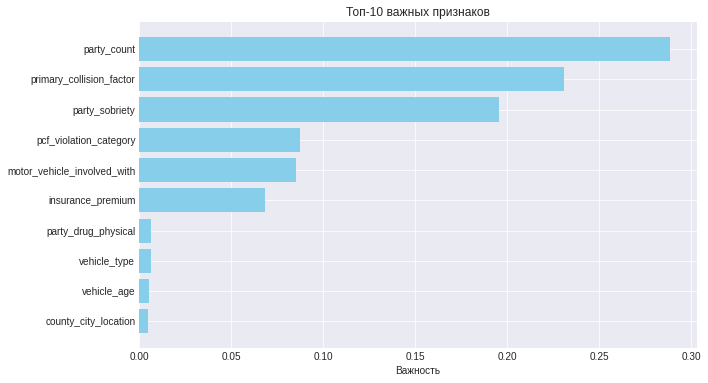

,feature,importance
0,party_count,0.288611
1,primary_collision_factor,0.230971
2,party_sobriety,0.195381
3,pcf_violation_category,0.087350
4,motor_vehicle_involved_with,0.085199
5,insurance_premium,0.068527
6,party_drug_physical,0.006552
7,vehicle_type,0.006371
8,vehicle_age,0.005240
9,county_city_location,0.004874


In [50]:
# Проверка важности признаков
if hasattr(best_model, 'named_steps'):
    classifier = best_model.named_steps['classifier']
else:
    classifier = best_model

# Важность признаков
feature_importances = classifier.feature_importances_

# Получение имен всех признаков
preprocessor = best_model.named_steps['preprocessor']

# Так как используется OrdinalEncoder, имена категориальных признаков остаются прежними
all_features = numeric_features + categorical_features

# Создание DataFrame с важностями признаков
feature_importances_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importances
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Вывод 10 самых важных признаков
top_features = feature_importances_df.head(10)

# График важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 важных признаков')
plt.gca().invert_yaxis()
plt.show()

# Вывод DataFrame с важностями признаков
feature_importances_df.reset_index(drop=True, inplace=True)
feature_importances_df

**На графике представлена важность 10 самых значимых признаков для предсказания ДТП. Из графика можно сделать следующие выводы:**

- party_count (Количество участников):

    - Является самым важным признаком для предсказания. Логично предположить, что чем больше участников в происшествии, тем выше вероятность его серьезности.
    
    
- primary_collision_factor (Основной фактор аварии):

    - Занимает второе место по важности. Этот признак отражает основную причину аварии и, естественно, является ключевым для понимания вероятности и тяжести ДТП.
    
    
- party_sobriety (Трезвость участника):

    - Важный фактор, влияющий на вероятность ДТП. Трезвость или нетрезвость водителя существенно влияет на вероятность возникновения аварийной ситуации.
    
    
- motor_vehicle_involved_with (Дополнительные участники ДТП):

    - Этот признак показывает, с чем столкнулось транспортное средство (например, другой автомобиль, объект на дороге и т.д.), что также критично для предсказания последствий аварии.
    
    
- pcf_violation_category (Категория нарушения):

    - Тип нарушения ПДД, допущенного водителем, оказывает значительное влияние на вероятность ДТП.
    
    
- insurance_premium (Сумма страховки):

    - Отражает экономический аспект и, возможно, уровень подготовки водителя или его осторожность на дороге.
    
    
- party_drug_physical (Состояние участника: физическое или с учетом принятых лекарств):

    - Этот признак включает в себя такие состояния, как усталость или нахождение под воздействием лекарств, что может сильно влиять на вероятность ДТП.
    
    
- vehicle_type (Тип автомобиля):

    - Разные типы автомобилей могут иметь различные характеристики безопасности и маневренности.
    
    
- vehicle_age (Возраст автомобиля):

    - Возраст автомобиля может влиять на его надежность и вероятность отказа систем, что тоже критично для оценки вероятности ДТП.
    
    
- county_city_location (Географическое расположение):

    - Разные географические районы могут иметь различную инфраструктуру, условия дорожного движения и частоту аварий.
    
    
Анализ важности признаков позволяет выделить ключевые факторы, влияющие на вероятность ДТП. Эти факторы могут быть использованы для дальнейшего анализа, улучшения мер безопасности на дорогах и разработки стратегий по снижению числа аварий. 

**Для одного из выявленных важных факторов проведем дополнительное исследование:**
- Покажем график зависимости фактора и целевой переменной.
- Предложим, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.

Проведем дополнительное исследование для фактора "party_sobriety" (Трезвость участника), так как этот фактор является важным для предсказания ДТП.

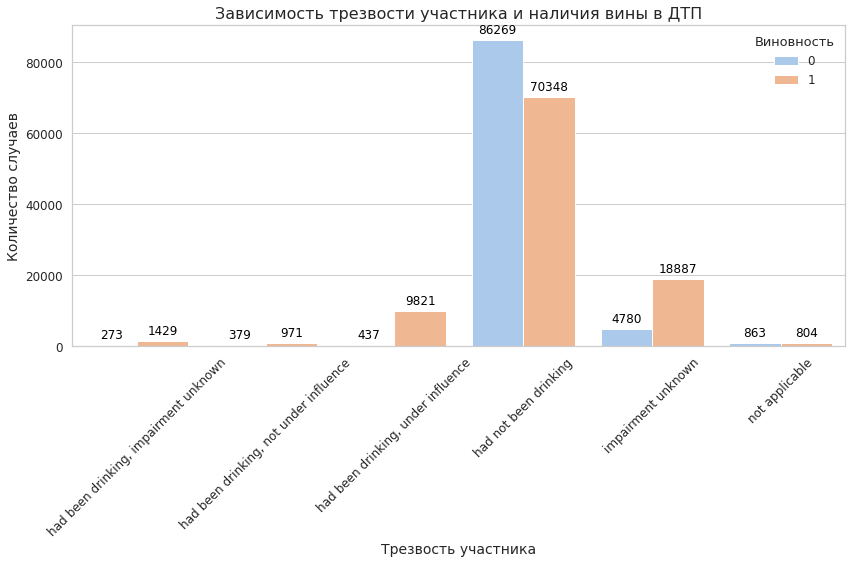

In [51]:
# Установка стиля графика
sns.set(style="whitegrid")

# Размеры фигуры
plt.figure(figsize=(12, 8))

# Построение графика
ax = sns.countplot(data=data, x='party_sobriety', hue='at_fault', palette='pastel')

# Подписи осей и заголовок
plt.xlabel('Трезвость участника', fontsize=14)
plt.ylabel('Количество случаев', fontsize=14)
plt.title('Зависимость трезвости участника и наличия вины в ДТП', fontsize=16)

# Поворот меток на оси X для улучшения читаемости
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Добавление аннотаций с количеством случаев
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Легенда
plt.legend(title='Виновность', fontsize=12, title_fontsize='13', loc='upper right')

# Отображение графика
plt.tight_layout()
plt.show()

**На графике представлена зависимость трезвости участника и наличия вины в ДТП. В частности, показано количество случаев для каждой категории трезвости с разделением по вине в аварии.**


- Категория "Had not been drinking":

    - Наибольшее количество случаев ДТП наблюдается среди участников, которые не употребляли алкоголь.
    - При этом значительная доля этих участников оказалась виновной в авариях.
    
    
- Категория "Had been drinking, under influence":

    - Участники, которые были под воздействием алкоголя, имеют высокую долю виновности в ДТП, что свидетельствует о значительном влиянии алкогольного опьянения на вероятность возникновения аварий.
    
    
- Категория "Impairment unknown":

    - Также выделяется значительное количество случаев с неизвестным состоянием ухудшения, где участники часто оказывались виновными в авариях.
    
    
- Категория "Not applicable":

    - В этой категории наблюдается небольшое количество случаев, что не позволяет сделать однозначные выводы о влиянии этой группы на аварийность.

**Рекомендации:**

- Алкотестер: Обеспечить автомобили алкотестерами, которые проверяют уровень алкоголя в дыхании водителя перед запуском двигателя.


- Система распознавания усталости и нарушения трезвости: Установить камеры и датчики, анализирующие поведение водителя и определяющие признаки усталости или алкогольного опьянения.


- Интеграция с носимыми устройствами: Синхронизировать системы автомобиля с носимыми устройствами (например, умными часами) для мониторинга состояния здоровья водителя в режиме реального времени.


Эти меры помогут повысить безопасность на дорогах и снизить вероятность ДТП, связанных с нарушением трезвости водителя.

## Выводы

- Кратко опишем результаты работы.

- Сделаем вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто?

- Какие факторы ещё необходимо собирать, чтобы улучшить модель?

- Мы выполнили запросы для подсчета количества строк в таблицах collisions, parties и vehicles.
- Результаты показали, что все три таблицы содержат данные.
- Мы выполнили запрос к системной таблице information_schema.tables, чтобы получить список всех таблиц в базе данных.
- Результаты показали, что в базе данных присутствуют все необходимые таблицы: collisions, parties и vehicles.

- Мы выполнили запрос к системной таблице information_schema.columns, чтобы проверить наличие столбца case_id в таблицах collisions, parties и vehicles.
- Результаты показали, что столбец case_id присутствует во всех трех таблицах.

- Мы выполнили запрос к системной таблице information_schema.key_column_usage, чтобы получить информацию о первичных и внешних ключах для таблиц collisions, parties и vehicles.
- Результаты показали, что в таблице collisions отсутствует явный первичный ключ.

- Все проведенные проверки подтверждают, что данные и таблицы в базе данных находятся в порядке.


- Провели статистический анализ факторов ДТП
- Выяснили, в какие месяцы происходит наибольшее количество аварий. Проанализировали весь период наблюдений (таблица collisions).

- Для совещания нашей рабочей группы, создали  подходящие аналитические задачи и поручили их решение коллегам.

- Провели анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связали collisions и parties);
- Нашли самые частые причины ДТП (таблица collisions).


- Выяснили, что лучшей моделью по результатам сравнительной таблицы является Gradient Boosting, показывающая наивысший F1-score. Эта модель имеет сбалансированные показатели precision и recall, что делает её наиболее подходящей.

**На основании результатов, Gradient Boosting рекомендована для дальнейшего использования.**


- На основе матрицы ошибок видно следующее:

    - Модель хорошо справляется с определением невиновных участников ДТП, но также имеет некоторую долю ошибок, когда невиновные были классифицированы как виновные).

- Precision-Recall Curve
    - Кривая Precision-Recall показывает, что модель достаточно хорошо справляется с балансировкой точности (Precision) и полноты (Recall). Кривая демонстрирует плавное снижение точности при увеличении полноты, что является нормальным для таких задач. Это подтверждает, что модель способна хорошо идентифицировать виновных участников ДТП.

- Изучили самые важные признаки

- Провели дополнительное исследование для фактора "party_sobriety" (Трезвость участника), так как этот фактор является важным для предсказания ДТП, предоставили также рекомендации.

На основе проведенного анализа и модели, можно сделать вывод, что создание адекватной системы оценки риска при выдаче автомобиля вполне возможно. Модель на основе машинного обучения показывает хорошую способность различать между виновными и невиновными участниками ДТП, что является ключевым элементом для оценки риска. 

Для дальнейшего улучшения модели оценки риска при выдаче автомобиля, следует собирать и анализировать дополнительные факторы, которые могут влиять на вероятность участия в ДТП. 


Вот несколько таких факторов:

- История вождения: Данные о предыдущих нарушениях ПДД, количестве и серьезности ДТП с участием водителя могут значительно улучшить прогнозирование риска.

- Состояние здоровья водителя: Информация о хронических заболеваниях, влияющих на способность к вождению (например, эпилепсия, диабет), а также об употреблении медикаментов.

- Психологический профиль: Оценка стрессоустойчивости, склонности к агрессивному вождению, наличия депрессивных состояний и других психологических факторов, влияющих на вождение.

- Образ жизни: Информация о режиме дня, частоте использования автомобиля, дальности и продолжительности поездок может помочь лучше понять поведенческие риски.

- Тип и состояние автомобиля: Данные о техническом состоянии автомобиля, наличии современных систем безопасности.

- Социально-экономический статус: Влияние уровня дохода, образования и профессиональной деятельности на поведение на дороге.

- Технические данные автомобиля: Информация о регулярности технического обслуживания, заменах важных компонентов (например, тормозной системы), установке зимних и летних шин и т.д.

Сбор и интеграция этих дополнительных данных помогут создать более точную и надежную систему оценки риска, которая будет учитывать комплексные факторы и снижать количество ошибок в прогнозировании. Это приведет к повышению безопасности на дорогах и более обоснованному подходу к выдаче автомобилей.